# FIT3139 Final Project

## Learning outcomes

1.  Explain and apply the process of computational scientific model building, verification and interpretation
2.  Analyse the differences between core classes of modelling approaches (Numerical versus Analytical; Linear versus Non-linear; Continuous versus Discrete; Deterministic versus Stochastic)
3.   Evaluate the implications of choosing different modelling approaches;
4.   Rationalise the role of simulation and data visualisation in science;
5.   Apply all of the above to solving idealisations of real-world problems across various scientific disciplines.

## Specification table
|||
|------------|---|
| Base Model | Tennis simulation |
| Extension assumpion | Simulate a complete season based on skill distribution |
| Techniques showcaed | Markov chains, montecarlo simulations |
| Modelling question 1 |  |
| Modelling question 2 | |

## Section 2: Introduction

### THe problem and the motivation

The primary problem addressed in this project is to understand the impact of skill distribution on player rankings in a tennis season. Additionally, the project aims to determine whether longer matches or longer seasons are more effective in revealing the true quality of players. This problem is motivated by the need to ensure fairness and accuracy in competitive sports, where ranking systems often determine players' career.

### Describe the extension and the questions my model will answer

I'm simulating a tennis match using markov chains. The extension is to simulate a complete season based on skill distribution. The base model discussed earlier used markov chain with "some" probability to move to a next point, which didn't take into account the skill level of a player. This extension will simplify the states in the transition matrix but will add complexity to take into account the player's serving and returning skills. The model will answer the following questions:

1. How does the skill distribution of players affect the outcome of a tennis tournament?
2. Comparing initial skill distribution vs point distribution at the end of the tournament.
3. What is more effective in revealing the true quality of players: longer matches or longer tournaments?

This question can be answered using other techniques such as game theory, however I have chosen markov chains as I believe it more accurately models a tennis players' skill level and allows me to examine how players of different skill levels perform in a match and whether they have any liklihood of winning. 
Sports do have a certain level of strategy involved, however given that I am using markov chains I am not considering that in this model and instead assuming that a player will always play the best shot possible, allowing me to focus on the skill level of a player.


### The rules of tennis
#### Points:
Each game starts with a serve and players alternate serving every game. Points are scored as follows: 0 (Love), 15, 30, 40, and game point.

#### Games:
A player wins a game by scoring four points and leading by at least two points. If the score reaches 40-40, the game is in deuce, and a player must win two consecutive points to win the game.

#### Sets:
A player wins a set by winning six games and leading by at least two games. If the score reaches 6-6, a tiebreaker is played to determine the winner of the set.

#### Match:
A player wins a match by winning the best of three or five sets.



## Section 3: Model description

### Model extension details

The base model used a markov chain to simulate a tennis match with equal probability for moving on to the next possible score. The extension will use a markov chain but will take into account the skill level of the players. Each player contains 2 skills - a serve and return skill. These skills will be represented by a number between 0 and 1, where 0 is the lowest skill level and 1 is the highest skill level.

The skill level of a players will be used to create a transition matrix. The creation of the transition matrix is based on the skill level of the 2 provided players.

The skill level will be used to determine the probability of a player winning a point when serving or returning. The skill level will be used to adjust the transition matrix probabilities to reflect the player's skill level. The model will simulate a complete season based on the skill distribution of the players


### Model assumptions

### Class of the model
#### Linear vs Non-linear


#### Continuous vs Discrete
##### Why discrete?
The model is discrete as the state space is finite and the transitions between states are discrete. The model is based on the outcome of each point in a tennis match. The model transitions between these states [serve, return, rally] based on the probability of transitioning to one of these states before stopping at one of the absorbing states where either the server wins or the returner wins. The model is discrete as the outcome of each point is an absolute value decided based on the transition matrices.

##### Why not continuous? 
Simulating a tennis match using a continuous model is not appropriate for answering my questions because I am only interested in the outcome of each point at the lowest level which is either a win or a loss (tennis does not have ties/draws). A continuous model could have been helpful if I was interested in the score of the match at any given point in time.

#### Deterministic vs Stochastic
In this markov chain tennis simulation, the model is stochastic as the outcome of each point is determined by a probability distribution. Each player has a skill level in terms of serving and returning, which affects the probability of winning a point. A higher serving level increases the likelihood of winning a point directly (ace) however, if the opponent has a high returning skill this probability is reduced/normalised to account for the opponent's skill level. Each point starts with one of the players serving; from this serving state the model transitions to one of the other possible transient states and the point end when either the server or returner wins a point. Given that each step is probabilistic, the model is stochastic.

### Algorithms being used


In [9]:
import numpy as np
import matplotlib.pyplot as plt
from functions.helper import *
from functions.transitionmatrix import *
from functions.simulation import *

### Transition matrix example

In my markov chain model, the transition matrix is a 5x5 matrix with the following states/structure:

S1: Serve

S2: Return

S3: Rally

S4: Point won by server

S5: Point won by returner

The transition matrix is as follows:

|    | S1 | S2  | S3  | S4   | S5   |
|----|----|-----|-----|------|------|
| S1 | 0  | 0.6 | 0   | 0.2  | 0.2  |
| S2 | 0  | 0   | 0.7 | 0.15 | 0.15 |
| S3 | 0  | 0   | 0.5 | 025  | 0.25 |
| S4 | 0  | 0   | 0   | 1    | 0    |
| S5 | 0  | 0   | 0   | 0    | 1    |


And in its canonical form:
From this matrix, we can extract the canonical form:

$$
\begin{align*}

\begin{pmatrix}
Q & R \\
0 & I \\
\end{pmatrix} & =

\begin{pmatrix}
0 & 0.6 & 0 & 0.2 & 0.2 \\
0 & 0 & 0.7 & 0.15 & 0.15 \\
0 & 0 & 0.5 & 0.25 & 0.25 \\
0 & 0 & 0 & 1 & 0 \\
0 & 0 & 0 & 0 & 1 \\
\end{pmatrix}

\\

Q & =
\begin{pmatrix}
0 & 0.6 & 0 \\
0 & 0 & 0.7 \\
0 & 0 & 0.5 \\
\end{pmatrix}


& R &=
\begin{pmatrix}
0.2 & 0.2 \\
0.15 & 0.15 \\
0.25 & 0.25 \\
\end{pmatrix}

\\

0 & =
\begin{pmatrix}
0 & 0 & 0 \\
0 & 0 & 0 \\
\end{pmatrix}


& I &=
\begin{pmatrix}
1 & 0 \\
0 & 1 \\
\end{pmatrix}

\end{align*}
$$

Getting the fundamental matrix:

$$
\begin{align*}
& N = (I - Q)^{-1} \\

& N = 
\begin{pmatrix}
1 & -0.6 & 0 \\
0 & 1 & -0.7 \\
0 & 0 & 1 \\
\end{pmatrix}^{-1} \\


\end{align*}
$$

See below for calculations

#### Caluclation for the example transition matrix

In [10]:
M = np.array([
    [0, 0.6, 0, 0.2, 0.2],
    [0, 0, 0.7, 0.15, 0.15],
    [0, 0, 0.5, 0.25, 0.25],
    [0, 0 ,0 ,1, 0],
    [0, 0, 0, 0, 1]
])
D = np.diag(M)
absorbing, transient = np.where(D==1)[0], np.where(D!=1)[0]
print("Absorbing states:", absorbing)  # rows 3 and 4
print("Transient states:", transient)  # rows 0, 1, 2

Absorbing states: [3 4]
Transient states: [0 1 2]


In [11]:
Q = M[:3,:3]
R = M[:3,3:]
N = np.linalg.inv(np.eye(3) - Q) # Fundamental matrix
expected_visits = np.sum(N, axis=1)
least_visitied = transient[np.argmin(expected_visits)]
absorbtion_time = N.dot(np.ones_like(transient))
total_time = np.sum(absorbtion_time)
# Probability of absoption = B_{ij} = NR
absorbtion_probabilities = N.dot(R)  # B = N * R

print("Expected visits:", expected_visits)
print("Least visited state:", least_visitied)
print("Absorbtion time:", absorbtion_time)
print("Total time:", total_time)
print("Absorbtion probabilities:\n", absorbtion_probabilities)

Expected visits: [2.44 2.4  2.  ]
Least visited state: 2
Absorbtion time: [2.44 2.4  2.  ]
Total time: 6.84
Absorbtion probabilities:
 [[0.5 0.5]
 [0.5 0.5]
 [0.5 0.5]]


The probability of reaching a state $M_{ij}$ in $n$ steps is given by $P_{ij}(n) = M^n_{ij}$

This formula is useful to examine the probability of reaching a state after a certain number of steps.

In [12]:
# calculating P_{ij}^{(n)} = M_{ij}^{(n)}
P = lambda n: np.linalg.matrix_power(M, n)
print("P_{ij}^{(1)}:\n", P(1))
print("P_{ij}^{(2)}:\n", P(2))
print("...")
print("P_{ij}^{(9)}:\n", P(9))

P_{ij}^{(1)}:
 [[0.   0.6  0.   0.2  0.2 ]
 [0.   0.   0.7  0.15 0.15]
 [0.   0.   0.5  0.25 0.25]
 [0.   0.   0.   1.   0.  ]
 [0.   0.   0.   0.   1.  ]]
P_{ij}^{(2)}:
 [[0.    0.    0.42  0.29  0.29 ]
 [0.    0.    0.35  0.325 0.325]
 [0.    0.    0.25  0.375 0.375]
 [0.    0.    0.    1.    0.   ]
 [0.    0.    0.    0.    1.   ]]
...
P_{ij}^{(9)}:
 [[0.         0.         0.00328125 0.49835937 0.49835937]
 [0.         0.         0.00273437 0.49863281 0.49863281]
 [0.         0.         0.00195312 0.49902344 0.49902344]
 [0.         0.         0.         1.         0.        ]
 [0.         0.         0.         0.         1.        ]]


We can see that as the number of steps increases, the probability of absorbing into either the server or returner winning increases, and we can also see that the probabilities of those 2 states is approaching 0.5.

## Section 4: Results

### Interpret and analyse my results

### How I arrived at my results


## Section 5: List of algorithms and concepts

### Markov chains - how it plays a role in my model

In [13]:
# Example usage:
server_skill = 0.8  # High skill server
returner_skill = 0.4  # Moderate skill returner
transition_matrix = create_transition_matrix(server_skill, returner_skill)
print(transition_matrix)


[[0.         0.33333333 0.         0.5        0.16666667]
 [0.         0.         0.2        0.6        0.2       ]
 [0.         0.         0.2        0.6        0.2       ]
 [0.         0.         0.         1.         0.        ]
 [0.         0.         0.         0.         1.        ]]


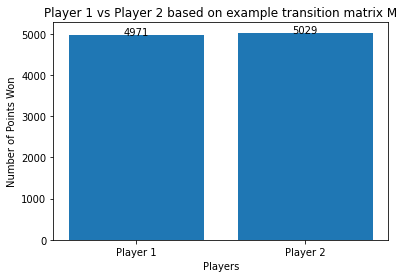

In [14]:
stats = {
    "Player 1": 0,
    "Player 2": 0,
}

for _ in range(10000):
    simulation = simulate_point(M)
    stats["Player 1"] += 1 if simulation[0] == 3 else 0
    stats["Player 2"] += 1 if simulation[0] == 4 else 0

plt.bar(stats.keys(), stats.values())
plt.xlabel("Players")
plt.ylabel("Number of Points Won")
plt.title("Player 1 vs Player 2 based on example transition matrix M")
for key, value in stats.items():
    plt.text(key, value, str(value), ha="center")
plt.show()

In [15]:
player1 = Player(0.7, 0.8)
player2 = Player(0.9, 0.4)
transition_matrices = create_transition_matrices(player1, player2)
simulate_match(player1, player2, transition_matrices)   

(2, 1)

In [16]:
class SingleEliminationTournament:
    def __init__(self, players, best_of=3):
        self.players = players
        self.best_of = best_of
        self.results = None

    # def simulate_round(self):
    #     winners = []
    #     for i in range(0, len(self.results), 2):
    #         player1, player2 = self.results[i], self.results[i + 1]
    #         transition_matrices = create_transition_matrices(player1, player2)
    #         winner = simulate_match(player1, player2, transition_matrices, best_of=self.best_of)
    #         winners.append(self.results[i] if winner[0] > winner[1] else self.results[i + 1])
    #     self.results = winners
    
    # def simulate(self):
    #     self.results = self.players
    #     while len(self.results) > 1:
    #         self.simulate_round()
    #         # for each winner, add 1 to their wins
    #         for player in self.results:
    #             player["wins"] += 1

    #     print(self.results)

    def simulate_round(self, player1, player2):
        transition_matrices = create_transition_matrices(player1, player2)
        winner = simulate_match(player1, player2, transition_matrices, best_of=self.best_of)
        return player1 if winner[0] > winner[1] else player2

    def simulate(self) -> list[Player]:
        """Simulates the tournament and returns the top 4 players. 
        This is a simple single elimination tournament and only works with more than 4 players. 
        I did not do error checking and handling of edge cases to keep the code and within the scope of the assignment.

        Returns:
            list[Player]: The top 4 players in the tournament
        """
        # make groups of 2
        brackets = [self.players[i:i+2] for i in range(0, len(self.players), 2)]
        while len(brackets) > 2:
            # there are more than 4 players remaining
            # simulate each bracket
            winners = []
            for bracket in brackets:
                winner = self.simulate_round(bracket[0], bracket[1])
                winners.append(winner)
            brackets = [winners[i:i+2] for i in range(0, len(winners), 2)]
        
        # there are 2 brackets remaining
        # simulate both of them and return the ranking of the players
        self.results = []
        final_winners = []
        final_loosers = []
        for bracket in brackets:
            winner = self.simulate_round(bracket[0], bracket[1])
            final_winners.append(winner)
            final_loosers.append(bracket[0] if winner == bracket[1] else bracket[1])
        # simulate the final match
        final_winner = self.simulate_round(final_winners[0], final_winners[1])
        final_looser = final_loosers[0] if final_winner == final_winners[1] else final_loosers[1]
        self.results = [final_winner, final_looser]
        # simulate the 3rd place match
        third_place = self.simulate_round(final_loosers[0], final_loosers[1])
        fourth_place = final_loosers[0] if third_place == final_loosers[1] else final_loosers[1]
        self.results.append(third_place)
        self.results.append(fourth_place)

        return self.results


players = [
    Player(0.7, 0.8),
    Player(0.9, 0.4),
    Player(0.6, 0.6),
    Player(0.5, 0.5),
    Player(0.8, 0.7),
    Player(0.4, 0.9),
    Player(0.6, 0.6),
    Player(0.5, 0.5),
]

tournament = SingleEliminationTournament(players, best_of=3)
tournament.simulate()

[Player(Serve=0.8, Return=0.7, name='', sets=2, games=6, score=4, wins=0),
 Player(Serve=0.6, Return=0.6, name='', sets=0, games=3, score=0, wins=0),
 Player(Serve=0.6, Return=0.6, name='', sets=2, games=6, score=4, wins=0),
 Player(Serve=0.6, Return=0.6, name='', sets=0, games=3, score=0, wins=0)]

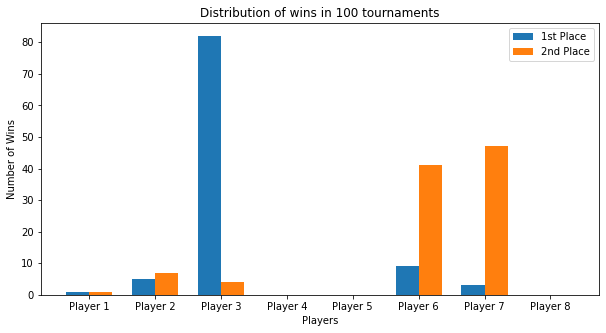

In [17]:
def get_stats(players, results):
    stats = {player["name"]: 0 for player in players}
    for player in results:
        stats[player["name"]] += 1
    return stats

# Lets simulate 1000 tournaments and see the distribution of wins
# set player names
def simulate_tournaments(players, best_of=3, num_tournaments=1000):
    for i, player in enumerate(players):
        player["name"] = f"Player {i + 1}"
    stats = {player["name"]: 0 for player in players}
    name_to_player = {player["name"]: player for player in players}

    all_results = []
    for _ in range(num_tournaments):
        tournament = SingleEliminationTournament(players, best_of=3)
        results = tournament.simulate()
        # for player in results:
        #     stats[player["name"]] += 1
        # winner = results[0]
        # stats[winner["name"]] += 1
        all_results.append(results)
    
    first_place = [result[0] for result in all_results]
    second_place = [result[1] for result in all_results]
    third_place = [result[2] for result in all_results]
    fourth_place = [result[3] for result in all_results]

    stats_first_place = get_stats(players, first_place)
    stats_second_place = get_stats(players, second_place)
    stats_third_place = get_stats(players, third_place)
    stats_fourth_place = get_stats(players, fourth_place)

    # histogram with 1st and 2nd place next to each other for each player

    fig, ax = plt.subplots()
    # increase figure size to show all player names
    fig.set_size_inches(10, 5)
    bar_width = 0.35
    index = np.arange(len(players))
    ax.bar(index, stats_first_place.values(), bar_width, label="1st Place")
    ax.bar(index + bar_width, stats_second_place.values(), bar_width, label="2nd Place")
    ax.set_xlabel("Players")
    ax.set_ylabel("Number of Wins")
    ax.set_title(f"Distribution of wins in {num_tournaments} tournaments")
    ax.set_xticks(index + bar_width / 2)
    ax.set_xticklabels(stats_first_place.keys())
    ax.legend()
    plt.show()

    
    # # increase figure size to show all player names
    # plt.figure(figsize=(10, 5))
    # plt.bar(stats.keys(), stats.values())
    # plt.xlabel("Players")
    # plt.ylabel("Number of Wins")
    # plt.title(f"Distribution of wins in {num_tournaments} tournaments")
    # for key, value in stats.items():
    #     plt.text(key, value, str(value), ha="center")
    #     player = name_to_player[key]

    # # legend to show player names and their stats
    # player_stats = [f"{player['name']} (Serve: {player['Serve']}, Return: {player['Return']})" for player in players]
    # handles = [plt.Rectangle((0,0),0,0, color=(31/255, 119/255, 180/255, 1)) for label in player_stats]
    # plt.legend(handles, player_stats, bbox_to_anchor=(1.05, 1), loc='upper left')
    # plt.show()

players = [
    Player(0.7, 0.8),
    Player(0.9, 0.4),
    Player(0.9, 0.6),
    Player(0.6, 0.6),
    Player(0.5, 0.5),
    Player(0.8, 0.7),
    Player(0.4, 0.9),
    Player(0.6, 0.6),
    # Player(0.6, 0.7),
    # Player(0.5, 0.5),
    # Player(0.8, 0.7),
    # Player(0.4, 0.9),
    # Player(0.9, 0.6),
    # Player(0.6, 0.6),
    # Player(0.6, 0.7),
    # Player(0.5, 0.5),
]

simulate_tournaments(players, num_tournaments=100)


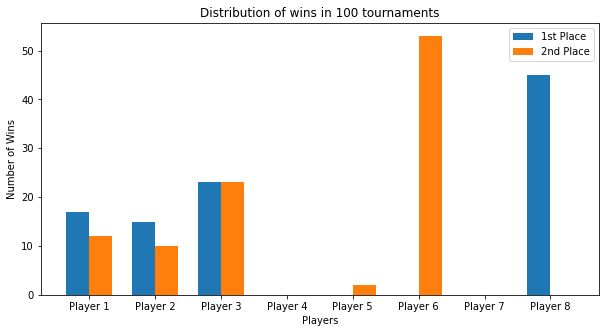

In [18]:
players = [
    Player(0.7, 0.8),
    Player(0.8, 0.7),
    Player(0.4, 0.9),
    Player(0.6, 0.6),
    Player(0.5, 0.5),
    Player(0.6, 0.6),
    Player(0.5, 0.5),
    Player(0.9, 0.4),
]

simulate_tournaments(players, num_tournaments=100)

In [19]:
player1 = Player(0.7, 0.8)
player2 = Player(0.9, 0.4)

# simulate a point many times
def _monte_carlo_point(player1, player2, reps=1000):
    winner_player1_serving = {
        "player1": 0,
        "player2": 0
    }
    winner_player2_serving = {
        "player1": 0,
        "player2": 0
    }
    transition_matrices = create_transition_matrices(player1, player2)
    
    for _ in range(reps):
        winner1, _ = simulate_point(transition_matrices[0])
        winner2, _ = simulate_point(transition_matrices[1])

        # winner 1 is when player 1 serves
        winner_player1_serving["player1"] += 1 if winner1 == 3 else 0
        winner_player1_serving["player2"] += 1 if winner1 == 4 else 0

        # winner 2 is when player 2 serves
        winner_player2_serving["player1"] += 1 if winner2 == 4 else 0
        winner_player2_serving["player2"] += 1 if winner2 == 3 else 0
    return "point", winner_player1_serving, winner_player2_serving

# simulate a set many times
def _monte_carlo_game(player1, player2, reps=1000):
    winner_player1 = {
        "player1": 0,
        "player2": 0
    }
    winner_player2 = {
        "player1": 0,
        "player2": 0
    }
    transition_matrices = create_transition_matrices(player1, player2)
    for _ in range(reps):
        winner1 = simulate_game(player1, player2, transition_matrices)
        winner2 = simulate_game(player2, player1, transition_matrices)

        winner_player1["player1"] += 1 if winner1[0] > winner1[1] else 0
        winner_player1["player2"] += 1 if winner1[0] < winner1[1] else 0

        winner_player2["player2"] += 1 if winner2[0] > winner2[1] else 0
        winner_player2["player1"] += 1 if winner2[0] < winner2[1] else 0

    return "set", winner_player1, winner_player2

# simulate a game many times
def _monte_carlo_set(player1, player2, reps=1000):
    winners = {
        "player1": 0,
        "player2": 0
    }
    transition_matrices = create_transition_matrices(player1, player2)
    
    for _ in range(reps):
        winner = simulate_set(player1, player2, transition_matrices)
        winners["player1"] += 1 if winner[0] > winner[1] else 0
        winners["player2"] += 1 if winner[0] < winner[1] else 0

    return "game", winners

# simulate a match many times
def _monte_carlo_match(player1, player2, reps=1000, best_of=3):
    winners = {
        "player1": 0,
        "player2": 0
    }
    transition_matrices = create_transition_matrices(player1, player2)
    
    for _ in range(reps):
        winner = simulate_match(player1, player2, transition_matrices, best_of=best_of)
        winners["player1"] += 1 if winner[0] > winner[1] else 0
        winners["player2"] += 1 if winner[0] < winner[1] else 0

    return "match", winners

def plot_monte_carlo_simulation(player1: Player, player2: Player, function, reps=1000) -> None:
    winners = function(player1, player2, reps)

    if len(winners) == 3:
        text, winner_player1_serving, winner_player2_serving = winners
        fig, ax = plt.subplots(1, 2, figsize=(10, 5))
        fig.suptitle(f"Monte Carlo Simulation of a {text}")
        ax[0].bar(winner_player1_serving.keys(), winner_player1_serving.values())
        ax[0].bar_label(ax[0].containers[0])
        ax[0].set_title("Player 1 Serving")
        ax[0].set_xlabel("Winner")
        ax[0].set_ylabel("Frequency")

        ax[1].bar(winner_player2_serving.keys(), winner_player2_serving.values())
        ax[1].bar_label(ax[1].containers[0])
        ax[1].set_title("Player 2 Serving")
        ax[1].set_xlabel("Winner")
        ax[1].set_ylabel("Frequency")
        plt.show()

    elif len(winners) == 2:
        text, winners = winners
        fig, ax = plt.subplots()
        fig.suptitle(f"Monte Carlo Simulation of a {text}")
        ax.bar(winners.keys(), winners.values())
        ax.bar_label(ax.containers[0])
        ax.set_title(text)
        ax.set_xlabel("Winner")
        ax.set_ylabel("Frequency")
        plt.show()
  

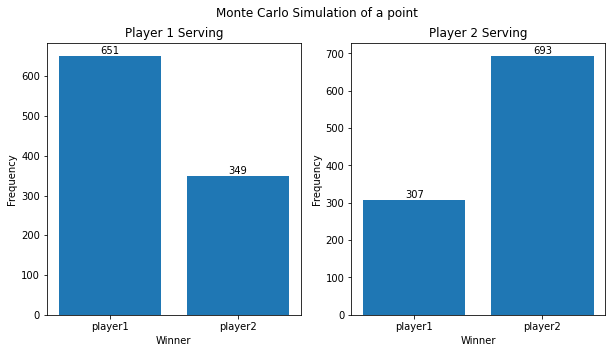

In [20]:
plot_monte_carlo_simulation(player1, player2, _monte_carlo_point)

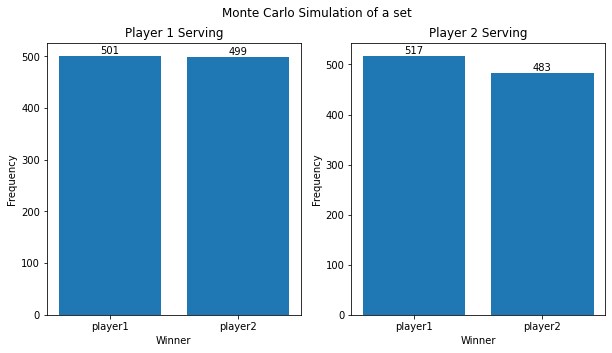

In [21]:
plot_monte_carlo_simulation(player1, player2, _monte_carlo_game)

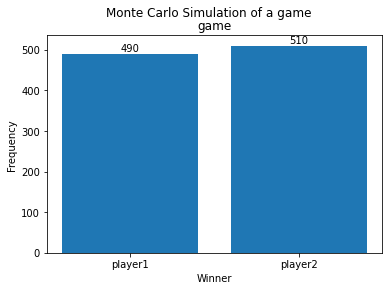

In [22]:
plot_monte_carlo_simulation(player1, player2, _monte_carlo_set)

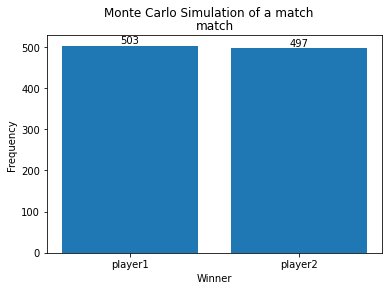

In [23]:
plot_monte_carlo_simulation(player1, player2, _monte_carlo_match)

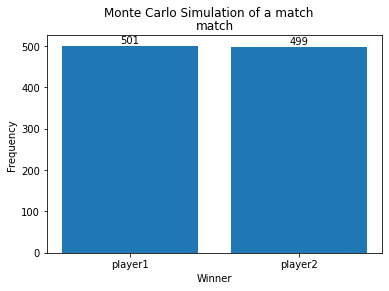

In [24]:
# plot monte carlo mathc with best of 5
plot_monte_carlo_simulation(player1, player2, lambda x, y, z: _monte_carlo_match(x, y, z, best_of=5))

C:\Users\rishi\AppData\Local\Temp\ipykernel_42616\3852250018.py:29: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


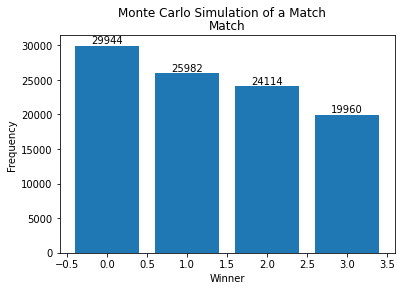

In [25]:
# showing that serve + return / 2 gives apprxiately the same result
players = np.array([
    Player(0.7, 0.8),
    Player(0.9, 0.4),
    Player(0.6, 0.6),
    Player(0.5, 0.5),
])

player_skill_level = np.vectorize(lambda x: (x.Serve + x.Return) / 2)(players)
p=proportional_scaling(player_skill_level)
sims=100000
winners = np.zeros(sims)

for i in range(sims):
    winner = np.random.choice(range(len(players)), p=p)
    winners[i] = winner

# change winners keys to player number
unique, counts = np.unique(winners, return_counts=True)
winners = dict(zip(unique, counts))

fig, ax = plt.subplots()
fig.suptitle("Monte Carlo Simulation of a Match")
ax.bar(winners.keys(), winners.values())
ax.bar_label(ax.containers[0])
ax.set_title("Match")
ax.set_xlabel("Winner")
ax.set_ylabel("Frequency")
fig.show()


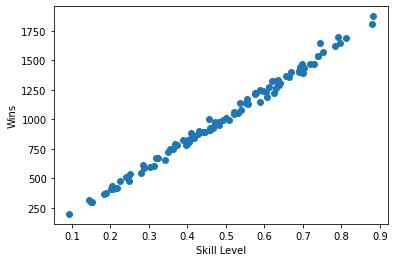

In [26]:
# Montecarlo simulation
# let the skill level of the players be server + return / 2

simulations = 100000
players = []
for _ in range(100):
    player = {
        "Serve": np.random.random(),
        "Return": np.random.random()
    }
    players.append(player)

player_skill_level = [(p["Serve"] + p["Return"]) / 2 for p in players]
# player skill level determines the probability of winning a point
# plot a histogram showing which player won the most points

winners = []
for _ in range(simulations):
    winner = np.random.choice(range(100), p=proportional_scaling(player_skill_level))
    winners.append(winner)

# plot skill level vs number of wins
plt.scatter(player_skill_level, [winners.count(i) for i in range(100)])
plt.xlabel("Skill Level")
plt.ylabel("Wins")
plt.show()

#### Heuristics - simulated annealing technique

Using the metropolis criterion for maximising f(x)

Given that tennis is a game that incorporates both these skills, the total skill level of a player is somewhere around the average of these skills. 

##### The perturb function
$$
perturb(players) = \text{swap 2 random players}
$$

##### Heuristic evaulation

$$
\Delta skill = \sum_{i=1}^{N} (Serve_{S'[i]} + Return_{S'[i]}) - \sum_{i=1}^{N} (Serve_{S[i]} + Return_{S[i]})
$$

##### Metropolis criterion / acceptance probability

$$
\text{Accept with probabaility} = 
\begin{cases}
    1 & \text{if} \Delta skill> 0 \\
    e^{\frac{-\Delta skill}{T}} & \text{otherwise}
\end{cases}
$$

##### Cooling process

$$
T_{new} = T_{old} \times \alpha
$$


In [27]:
def perturb(players):
    i, j = np.random.choice(range(len(players)), 2, replace=False)
    new_players = np.copy(players)
    new_players[i], new_players[j] = new_players[j], new_players[i]
    return new_players


def heuristic_simulate_tournament(players, t0, cooling_factor, perturbations=1000):
    players = np.array(players)
    number_of_players = len(players)
    current_solution = np.random.permutation(players)
    t = t0

    while t > 0.001:
        for _ in range(perturbations):
            new_solution = perturb(current_solution)
            delta = np.sum([new_solution[i]["Serve"] + new_solution[i]["Return"] - current_solution[i]["Serve"] - current_solution[i]["Return"] for i in range(number_of_players)])
            if delta > 0 or np.random.random() < np.exp(-delta / t):
                current_solution = new_solution
        t *= cooling_factor

    return current_solution

players = np.array([
    Player(0.7, 0.8),
    Player(0.6, 0.6),
    Player(0.9, 0.4),
    Player(0.5, 0.5),
    Player(0.9, 0.2),
    Player(0.1, 0.9),
    Player(0.9, 0.4),
    Player(0.1, 0.1),
])

heuristic_simulate_tournament(players, 100, 0.95)

array([Player(Serve=0.9, Return=0.4, name='', sets=0, games=0, score=0, wins=0),
       Player(Serve=0.9, Return=0.2, name='', sets=0, games=0, score=0, wins=0),
       Player(Serve=0.5, Return=0.5, name='', sets=0, games=0, score=0, wins=0),
       Player(Serve=0.9, Return=0.4, name='', sets=0, games=0, score=0, wins=0),
       Player(Serve=0.1, Return=0.1, name='', sets=0, games=0, score=0, wins=0),
       Player(Serve=0.6, Return=0.6, name='', sets=0, games=0, score=0, wins=0),
       Player(Serve=0.7, Return=0.8, name='', sets=0, games=0, score=0, wins=0),
       Player(Serve=0.1, Return=0.9, name='', sets=0, games=0, score=0, wins=0)],
      dtype=object)

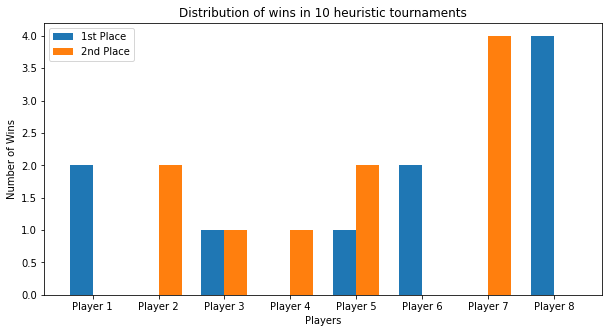

In [28]:
# run heuristic simulation 100 times and plot
def simulate_heuristic_tournament(players, t0, cooling_factor, perturbations=100, num_simulations=10):
    first_place = []
    second_place = []
    # set player names
    for i, player in enumerate(players):
        player["name"] = f"Player {i + 1}"

    for _ in range(num_simulations):
        result = heuristic_simulate_tournament(players, t0, cooling_factor, perturbations)
        first_place.append(result[0])
        second_place.append(result[1])

    stats_first_place = get_stats(players, first_place)
    stats_second_place = get_stats(players, second_place)

    fig, ax = plt.subplots()
    # increase figure size to show all player names
    fig.set_size_inches(10, 5)
    bar_width = 0.35
    index = np.arange(len(players))
    ax.bar(index, stats_first_place.values(), bar_width, label="1st Place")
    ax.bar(index + bar_width, stats_second_place.values(), bar_width, label="2nd Place")
    ax.set_xlabel("Players")
    ax.set_ylabel("Number of Wins")
    ax.set_title(f"Distribution of wins in {num_simulations} heuristic tournaments")
    ax.set_xticks(index + bar_width / 2)
    ax.set_xticklabels(stats_first_place.keys())
    ax.legend()
    plt.show()
        
    
simulate_heuristic_tournament(players, 100, 0.95)